In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

from scipy import ndimage

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
models_path = data_dir / "models"
train_images_crops = data_dir/"train_crops"
mask_dir_edt = data_dir /"mask_full_size_edt"
train_mask_crops = data_dir/"mask_crops_single_channel"
label_dir = data_dir/"train"/"labels"
mask_crops_edt = data_dir/"mask_crops_edt"

In [3]:
def create_mask(json_file, data_dir, mask_dir, tile_size=1024):
    with open(data_dir/"train"/"labels"/json_file, 'r') as f:
        label = json.load(f)
    label_gdf = parse_json(label)
    if label_gdf is None or len(label_gdf) == 0:
        return
    fb_mask = sol.vector.mask.df_to_px_mask(df=label_gdf, geom_col="geometry_pixel",
                                         channels=['footprint'],
                                         shape=(tile_size,tile_size)).squeeze()
    # print(fb_mask.shape)
    PIL.Image.fromarray(fb_mask, mode='L').save(mask_dir/(json_file.replace('.json', '.png')))

#### mask creation test

In [4]:
pre_images = [x for x in mask_dir.ls() if 'pre_' in x.name]
pre_images[10]

PosixPath('/media/wwymak/Storage/xView2/mask_full_size/hurricane-harvey_00000022_pre_disaster.png')

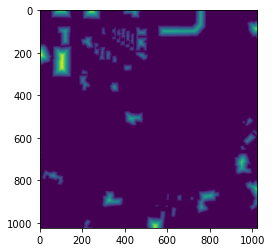

In [13]:
sample_mask = np.array(PIL.Image.open(pre_images[10]))[:,:,0] /255
inverted_sample_mask = 1 - sample_mask
transformed = ndimage.distance_transform_edt(sample_mask)
trasformed_inverted = ndimage.distance_transform_edt(inverted_sample_mask) * -1
plt.imshow(transformed / transformed.max() * 255)

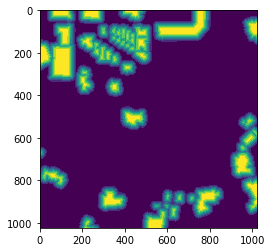

In [31]:
combined = transformed + trasformed_inverted

bins =np.arange(-20, 20, 5)
combined_binned = np.digitize(combined, bins, right=False)
plt.imshow(combined_binned / combined_binned.max() * 255)


In [32]:
np.unique(combined_binned)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [24]:
trasformed_inverted_binned.shape

(1024, 1024)

#### after runnign create_edt_mask.py

8 0 [0 1 2 3 4 5 6 7 8]


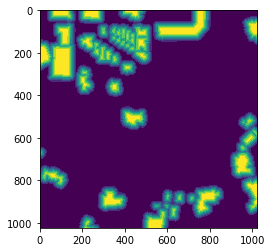

In [11]:
# run create_edt_mask.py
# sanity check:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir_edt = data_dir /"mask_full_size_edt"
sample_file = mask_dir_edt.ls()[10]

img = np.array(PIL.Image.open(sample_file))
plt.imshow(img)

print(img.max(), img.min(), np.unique(img))

#### Create crops

In [7]:
mask_dir_edt.ls()[:2]

[PosixPath('/media/wwymak/Storage/xView2/mask_full_size_edt/midwest-flooding_00000319_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/mask_full_size_edt/hurricane-florence_00000392_pre_disaster.png')]

In [13]:
from mask_extraction import create_small_tiles_masks
from tqdm import tqdm_notebook

mask_crops_edt = data_dir/"mask_crops_edt"
mask_crops_edt.mkdir(exist_ok=True)

create_tile = partial(create_small_tiles_masks, save_dir=mask_crops_edt)
mask_filepaths_edt = mask_dir_edt.ls()
# [create_tile(img_filepath, mask_filepath, im_id) for (img_filepath, mask_filepath, im_id) in zip(img_filepaths, mask_filepaths, img_ids )]
_ = Parallel(n_jobs=14)(delayed(create_tile)(mask_filepath)for mask_filepath in tqdm(mask_filepaths_edt))
# fro


100%|██████████| 2283/2283 [00:08<00:00, 266.42it/s]


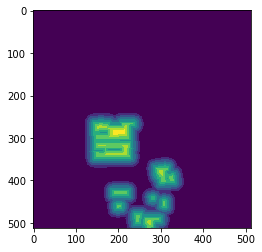

In [18]:
a = np.array(PIL.Image.open(mask_crops_edt.ls()[100]))
a.max(), a.min()
plt.imshow(a/a.max() * 255)

In [27]:
train_images_crops.ls()[10]

PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_hurricane-matthew_00000245_pre_disaster._8.png')

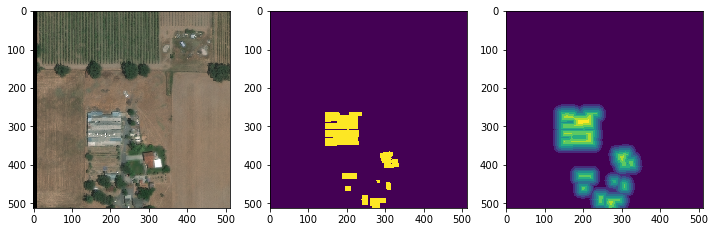

In [30]:
fname = "mask_santa-rosa-wildfire_00000136_pre_disaster_1.png"
a = np.array(PIL.Image.open(mask_crops_edt /fname))
b = np.array(PIL.Image.open(train_mask_crops/fname.replace("disaster_", "disaster._")))
c = np.array(PIL.Image.open(train_images_crops/fname.replace('mask', 'rgb').replace("disaster_", "disaster._")))

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axs = ax.ravel()
axs[0].imshow(c)
axs[1].imshow(b/b.max() * 255)
axs[2].imshow(a/a.max() * 255)
# train_mask_crops

#### first attempt at multitask net fastai 

In [4]:
unique_img_ids = list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() ]))
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [5]:
def is_valid_func(fname):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)
    
    

In [6]:

size=256
bs=16
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom


class SegLabelListEdt(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=False, convert_mode='I')

class SegItemListEdt(SegmentationItemList):
    _label_cls = SegLabelListEdt
    
segmentation_labels = (
    SegItemListCustom.from_folder(train_images_crops)
      .split_by_valid_func(is_valid_func)
       .label_from_func(lambda fname: train_mask_crops / fname.name.replace("rgb", "mask"), classes=["void", "building"])
)
edt_labels = (
    SegItemListEdt.from_folder(train_images_crops)
      .split_by_valid_func(is_valid_func)
       .label_from_func(lambda fname: mask_crops_edt / fname.name.replace("rgb", "mask").replace("disaster._", "disaster_"),
                        classes=np.arange(0, 9)
        )
)

In [7]:
accuracy_pixel=partial(foreground_acc, void_code=0)
f1_score = partial(fbeta, thresh=0.2, beta = 1)

wd =1e-2

metrics = [accuracy_pixel,dice]

multitask_project = {
    'segmentation': {
        'label_lists': segmentation_labels,
        'metric': metrics
    },
    'edt': {
        'label_lists': edt_labels,
        'metric': metrics
    }
}


#### Sanity check single models

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


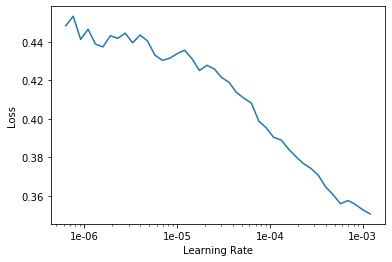

In [47]:
del learn
gc.collect()
# src = (SegItemListCustom.from_folder(train_images_crops)
#       .split_by_valid_func(is_valid_func)
#        .label_from_func(lambda fname: train_mask_crops / fname.name.replace("rgb", "mask"), classes=['void', 'building']))

data_segmentation = (segmentation_labels.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


learn = unet_learner(data_segmentation, models.resnet34, metrics=multitask_project["segmentation"]["metric"])
learn.to_fp16();
learn.lr_find()
learn.recorder.plot();



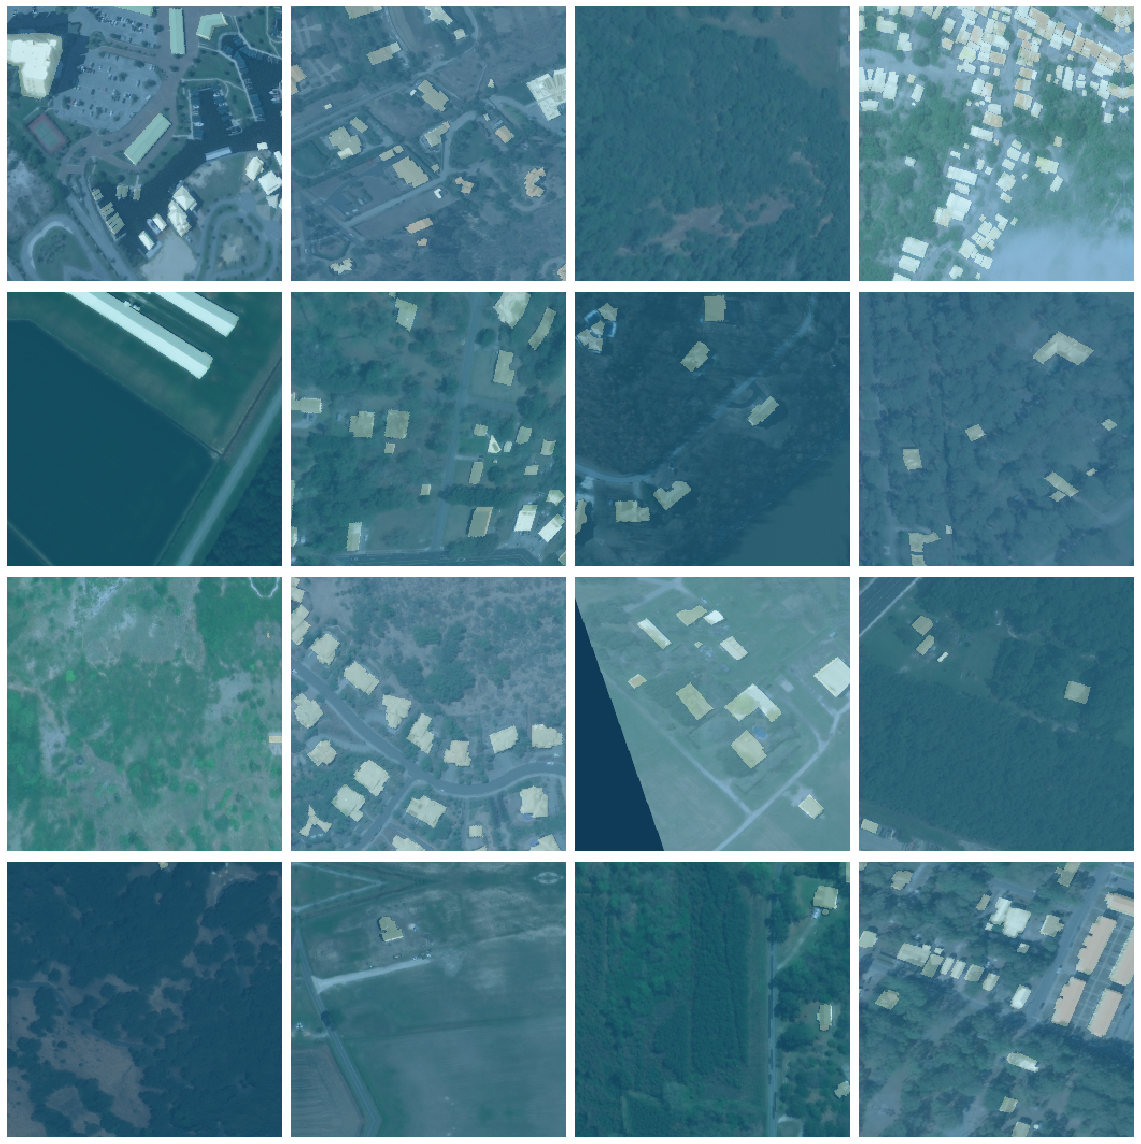

In [48]:
data_segmentation.show_batch()

In [49]:
wd=1e-2
lr=1e-4

learn.model_dir = models_path
callbacks=[
#     SaveModelCallback(learn, every='improvement', monitor='f1_score', name='xview_buildings_default_unet'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn.fit_one_cycle(5, slice(lr), callbacks=callbacks, wd=wd)

In [ ]:
class BCEDice(nn.Module):

    def __init__(self, dice=0.5, bce=0.5):
        super(CustomLoss, self).__init__()
        self.dice = dice
        self.bce = bce

    def forward(self, input, target, **kwargs):
        logits=input[:,1,:,:].float()
        labels = target.squeeze(1).float()
                     
        bce_dice = BCEDiceLoss(dice_weight=self.dice, bce_weight=self.bce)
        
        total_loss = bce_dice(logits, labels) #+ 0.2 * lovaz_loss(logit, target)
        return total_loss


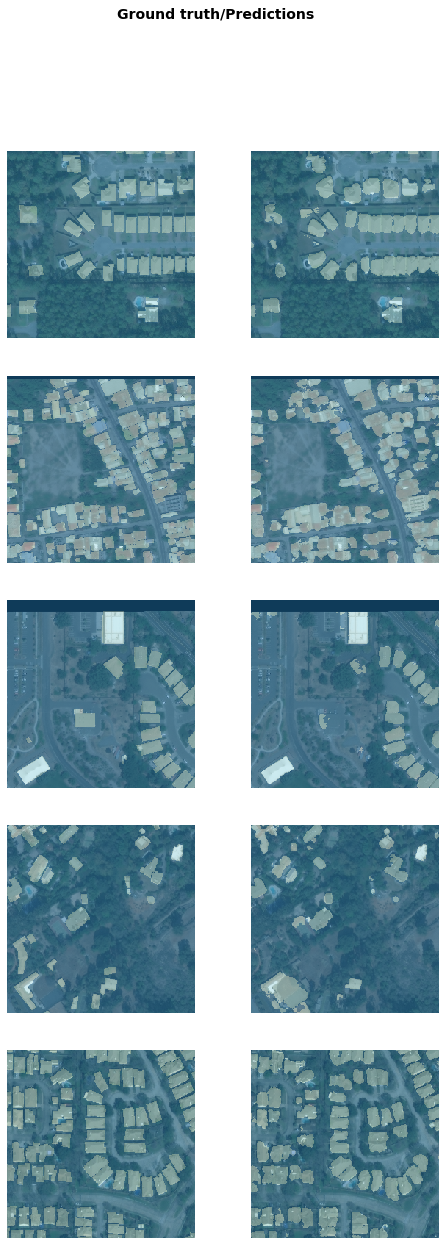

In [51]:
learn.show_results()

In [ ]:
learn.loss_func = BCEDice(dice=0.8, bce=0.2)

In [7]:
bs = 8
size=256
data_edt = (edt_labels.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data_edt.show_batch()


In [13]:
def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
                             dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.long().unsqueeze(1), 1)
    
def multiclass_dice(input:Tensor, targs:Tensor, num_classes, eps:float=1e-8)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."

    targs = to_onehot(targs, num_classes=num_classes).squeeze()
    input = to_onehot(input.argmax(dim=1), num_classes=num_classes).squeeze()
#     print(input.shape, targs.shape)
    intersect = (input * targs).sum(dim=1).float()
    print(intersect.shape)
    union = (input+targs).sum(dim=1).float()
    print(intersect.shape(), union.shape(), intersect.sum(), union.sum())
    l = 2. * intersect / (union + eps)

    return l.mean()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


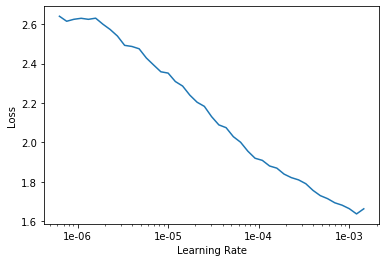

In [9]:
accuracy_pixel=partial(foreground_acc, void_code=0)
dice_custom = partial(multiclass_dice, num_classes=9)
wd =1e-2
learn_edt = unet_learner(data_edt, models.resnet34, metrics=[accuracy_pixel,dice_custom])
learn_edt.to_fp16();
learn_edt.lr_find()
learn_edt.recorder.plot();



In [11]:
sample = learn_edt.data.train_ds[0][0]
test_pred = learn_edt.predict(sample)
test_pred

(ImageSegment (1, 256, 256), tensor([[[2, 2, 6,  ..., 1, 0, 0],
          [2, 4, 4,  ..., 1, 0, 4],
          [4, 4, 4,  ..., 1, 4, 4],
          ...,
          [2, 4, 4,  ..., 2, 4, 4],
          [7, 4, 4,  ..., 4, 4, 4],
          [1, 4, 4,  ..., 4, 4, 4]]]), tensor([[[0.0996, 0.0941, 0.0665,  ..., 0.0745, 0.2199, 0.2507],
          [0.1063, 0.1005, 0.0751,  ..., 0.0703, 0.2528, 0.1808],
          [0.1115, 0.0941, 0.0719,  ..., 0.0545, 0.1720, 0.1912],
          ...,
          [0.0589, 0.0529, 0.0646,  ..., 0.0627, 0.0589, 0.0538],
          [0.0695, 0.0664, 0.0591,  ..., 0.0599, 0.0545, 0.0459],
          [0.0670, 0.0533, 0.0563,  ..., 0.0483, 0.0421, 0.0456]],
 
         [[0.1054, 0.1057, 0.1310,  ..., 0.2818, 0.1558, 0.1128],
          [0.1123, 0.1150, 0.1306,  ..., 0.3238, 0.1920, 0.1457],
          [0.1039, 0.0977, 0.1348,  ..., 0.3166, 0.1856, 0.1348],
          ...,
          [0.1620, 0.1134, 0.1193,  ..., 0.1077, 0.1001, 0.1157],
          [0.1389, 0.1123, 0.1133,  ..., 0.136

In [29]:
b = to_onehot(test_pred[1], 9)
b.dtype, b.shape, test_pred[1].dtype

(torch.uint8, torch.Size([1, 9, 256, 256]), torch.int64)

In [31]:
a = to_onehot(learn_edt.data.train_ds[0][1].data, 9)
b = to_onehot(test_pred[1], 9)

multiclass_dice(a, b, num_classes=9)

torch.uint8 torch.Size([1, 9, 256, 256])
torch.Size([1, 9, 256, 256]) torch.Size([9, 9, 256, 256])
tensor(65536.) tensor(1179648.)


tensor(0.0273)

In [15]:
lr=1e-4
data_edt.use_partial_data(0.2)
learn_edt.metrics = [accuracy_pixel,dice_custom]
learn_edt.data = data_edt
learn_edt.model_dir = models_path
callbacks=[
#     SaveModelCallback(learn, every='improvement', monitor='f1_score', name='xview_buildings_default_unet'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn_edt, patience=1)
          ]

learn_edt.fit_one_cycle(1, slice(lr), callbacks=callbacks)

tensor(4131153.5000, device='cuda:0') tensor(384018.0938, device='cuda:0')
tensor(2771826., device='cuda:0') tensor(259996.0156, device='cuda:0')
tensor(3912524.5000, device='cuda:0') tensor(424075.4375, device='cuda:0')
tensor(3574856.5000, device='cuda:0') tensor(410370.8125, device='cuda:0')
tensor(3122547., device='cuda:0') tensor(501840., device='cuda:0')
tensor(2988890., device='cuda:0') tensor(417043.5625, device='cuda:0')
tensor(2768683., device='cuda:0') tensor(402937.2188, device='cuda:0')
tensor(3587102., device='cuda:0') tensor(507737.6875, device='cuda:0')
tensor(4682318., device='cuda:0') tensor(370300.2812, device='cuda:0')
tensor(4179974., device='cuda:0') tensor(565633.6250, device='cuda:0')
tensor(3591969., device='cuda:0') tensor(432985.0625, device='cuda:0')
tensor(3777290.5000, device='cuda:0') tensor(591552.6875, device='cuda:0')
tensor(4651103., device='cuda:0') tensor(502608.4688, device='cuda:0')
tensor(3239578., device='cuda:0') tensor(552166., device='cuda:0'

tensor(3335480.7500, device='cuda:0') tensor(377576.5000, device='cuda:0')
tensor(3826257.5000, device='cuda:0') tensor(484186.0625, device='cuda:0')
tensor(3870029., device='cuda:0') tensor(476717.3125, device='cuda:0')
tensor(3783728., device='cuda:0') tensor(464975.8438, device='cuda:0')
tensor(3434428., device='cuda:0') tensor(461749.3438, device='cuda:0')
tensor(3487384.7500, device='cuda:0') tensor(402172.9062, device='cuda:0')
tensor(4275581., device='cuda:0') tensor(356118.9062, device='cuda:0')
tensor(3611318.5000, device='cuda:0') tensor(369361.6875, device='cuda:0')
tensor(3315892.5000, device='cuda:0') tensor(409860.0938, device='cuda:0')
tensor(3262298.7500, device='cuda:0') tensor(424351.8750, device='cuda:0')
tensor(3449049.5000, device='cuda:0') tensor(557549.6250, device='cuda:0')
tensor(3224327.5000, device='cuda:0') tensor(413743.3750, device='cuda:0')
tensor(2997265., device='cuda:0') tensor(403115.6875, device='cuda:0')
tensor(3782245.2500, device='cuda:0') tensor(

tensor(2917495., device='cuda:0') tensor(490252.3750, device='cuda:0')
tensor(3696573.5000, device='cuda:0') tensor(549479.4375, device='cuda:0')
tensor(3516504.5000, device='cuda:0') tensor(602237.5000, device='cuda:0')
tensor(4576836.5000, device='cuda:0') tensor(415868.8125, device='cuda:0')
tensor(2540828.7500, device='cuda:0') tensor(341280.0625, device='cuda:0')
tensor(3980509., device='cuda:0') tensor(247574.6875, device='cuda:0')
tensor(4100020., device='cuda:0') tensor(437301., device='cuda:0')
tensor(3477525.7500, device='cuda:0') tensor(324963.7500, device='cuda:0')
tensor(3586746.7500, device='cuda:0') tensor(477815.9688, device='cuda:0')
tensor(3207353., device='cuda:0') tensor(485109.3750, device='cuda:0')
tensor(2486640.5000, device='cuda:0') tensor(327756.5000, device='cuda:0')
tensor(3962622., device='cuda:0') tensor(521851.9688, device='cuda:0')
tensor(3858016.5000, device='cuda:0') tensor(528771.5000, device='cuda:0')
tensor(3751403.5000, device='cuda:0') tensor(4517

tensor(2992777.2500, device='cuda:0') tensor(297471.3438, device='cuda:0')
tensor(3194053.2500, device='cuda:0') tensor(360278.7500, device='cuda:0')
tensor(2923812.5000, device='cuda:0') tensor(473301.6250, device='cuda:0')
tensor(3528491.5000, device='cuda:0') tensor(429656.0938, device='cuda:0')
tensor(3524278.5000, device='cuda:0') tensor(357649.5000, device='cuda:0')
tensor(2748996.5000, device='cuda:0') tensor(498356.5938, device='cuda:0')
tensor(3582061., device='cuda:0') tensor(626847.2500, device='cuda:0')
tensor(3679168.5000, device='cuda:0') tensor(535712.6250, device='cuda:0')
tensor(3286835.2500, device='cuda:0') tensor(490979., device='cuda:0')
tensor(2642541., device='cuda:0') tensor(432248.7188, device='cuda:0')
tensor(4101848., device='cuda:0') tensor(392684.3125, device='cuda:0')
tensor(3046194.2500, device='cuda:0') tensor(568632., device='cuda:0')
tensor(3600488., device='cuda:0') tensor(430158.4375, device='cuda:0')
tensor(4654375., device='cuda:0') tensor(494237.4

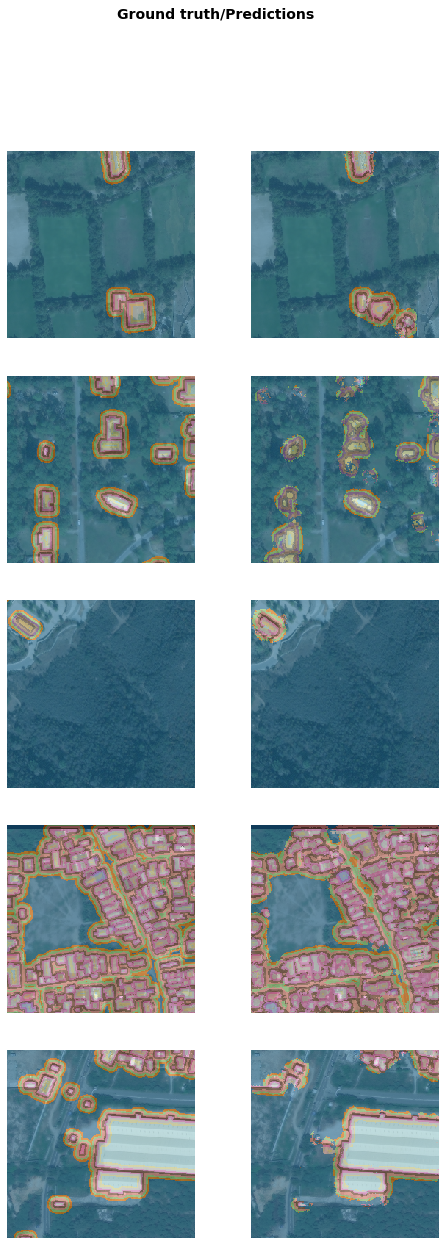

In [13]:
learn_edt.show_results()

In [36]:
model_summary(learn_edt)

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________

In [27]:

unet_model = learn_edt.model
unet_model
# nn.Sequential(*list(unet_model.children())[:-2])
# res50_conv2 = ResNet50Bottom(res50_model)

# unet_model[10].layers[2]#.ff.layers[0]


# create_body(unet_model, 
#             cut=-5)

nn.Sequential(SequentialEx(unet_model[:10]), SequentialEx(unet_model[10:]))

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (4): Sequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (1): BasicBlock(
              (conv1): Conv2d(64, 64, 

In [31]:
class EdtNet(nn.Module):
    def __init__(self, architecture=models.resnet34, 
                 lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False, n_classes=4):
        super(EdtNet, self).__init__()
        
        self.architecture= architecture
        self.emb_sz = emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = SequentialEx(unet_model[:-2])
        self.head_segment = 
        
        self.head = learner.create_head(num_features_model(self.body) , self.emb_sz, 
                                        self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)
        print(self.cnn, 'self.cnn')
        self.output = nn.Linear(num_features_model(self.cnn), n_classes)

                                  
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        dist = torch.abs(output1-output2)
    
        
        return self.output(dist)

    def get_embedding(self, x):
        return self.cnn(x)

AttributeError: 'tuple' object has no attribute 'cuda'

In [ ]:
dice_custom()

In [42]:
class MultitaskDataset(Dataset):
    "`Dataset` for joint single and multi-label image classification."
    def __init__(self, 
                 fns,
                 labels_gender,
                 labels_race,
                 ages,
                 classes_race,
                 classes_gender):
        self.x = np.array(fns)
        
        self.classes_gender = classes_gender
        self.classes_race = classes_race

        self.class2idx_gender = {v:k for k,v in enumerate(self.classes_gender)}
        self.y_gender = np.array([self.class2idx_gender[o] for o in labels_gender], dtype=np.int64)

        self.class2idx_race = {v:k for k,v in enumerate(self.classes_race)}
        self.y_race = np.array([self.class2idx_race[o] for o in labels_race], dtype=np.int64)
        
        self.y_age = ages[:, None].astype('float32')
        
        self.c_gender = len(classes_gender)
        self.c_race = len(classes_race)
        self.c_age = 1

        self.c = self.c_gender + self.c_race + self.c_age

    
    def __len__(self): return len(self.x)
    
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray, np.ndarray]: 
        return open_image(self.x[i]), torch.tensor([self.y_gender[i], self.y_race[i], self.y_age[i]]).float()
    
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'
In [261]:
def get_dataset(df):
    return MultitaskDataset(df.img_name, 
                            labels_gender=df.gender, 
                            labels_race=df.race,
                            ages=df.age,
                            classes_race=sorted(set(df.race)),
                            classes_gender=sorted(set(df.gender))
                           )

In [46]:
learn_edt.split(lambda m: m[9])

Learner(data=ImageDataBunch;

Train: LabelList (12688 items)
x: SegItemListEdt
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListEdt
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Valid: LabelList (3077 items)
x: SegItemListEdt
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListEdt
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R

In [24]:
c = torch.Tensor([[0], [1], [2]]).long()
d =to_onehot(c, 4)
d.shape, d.squeeze().shape

(torch.Size([3, 4, 1]), torch.Size([3, 4]))

In [43]:
learn_edt

Learner(data=ImageDataBunch;

Train: LabelList (12688 items)
x: SegItemListEdt
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListEdt
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Valid: LabelList (3077 items)
x: SegItemListEdt
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListEdt
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/xView2/train_crops;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R